# Student_Performance

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd
import scipy
import seaborn as sns
import math
import pickle

from scipy.io import arff
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (confusion_matrix,plot_confusion_matrix,
                            ConfusionMatrixDisplay,accuracy_score,f1_score,
                            mean_squared_error, mean_absolute_error, max_error,
                            r2_score, explained_variance_score)

from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RBF,WhiteKernel,DotProduct
from sklearn.neural_network import MLPRegressor

## Loading Data

In [2]:
Dataset = pd.read_csv('Regression_Datasets/6_Student_Performance/Student_Performance.csv', delimiter=';') 
Dataset.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


## Data Prepration And Analysis

In [3]:
Dataset.isnull().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64

In [4]:
print(np.count_nonzero(Dataset==np.nan))

0


In [5]:
Dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

In [6]:
Dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
age,649.0,16.744222,1.218138,15.0,16.0,17.0,18.0,22.0
Medu,649.0,2.514638,1.134552,0.0,2.0,2.0,4.0,4.0
Fedu,649.0,2.306626,1.099931,0.0,1.0,2.0,3.0,4.0
traveltime,649.0,1.568567,0.748660,1.0,1.0,1.0,2.0,4.0
studytime,649.0,1.930663,0.829510,1.0,1.0,2.0,2.0,4.0
failures,649.0,0.221880,0.593235,0.0,0.0,0.0,0.0,3.0
famrel,649.0,3.930663,0.955717,1.0,4.0,4.0,5.0,5.0
freetime,649.0,3.180277,1.051093,1.0,3.0,3.0,4.0,5.0
goout,649.0,3.184900,1.175766,1.0,2.0,3.0,4.0,5.0
Dalc,649.0,1.502311,0.924834,1.0,1.0,1.0,2.0,5.0


<AxesSubplot:>

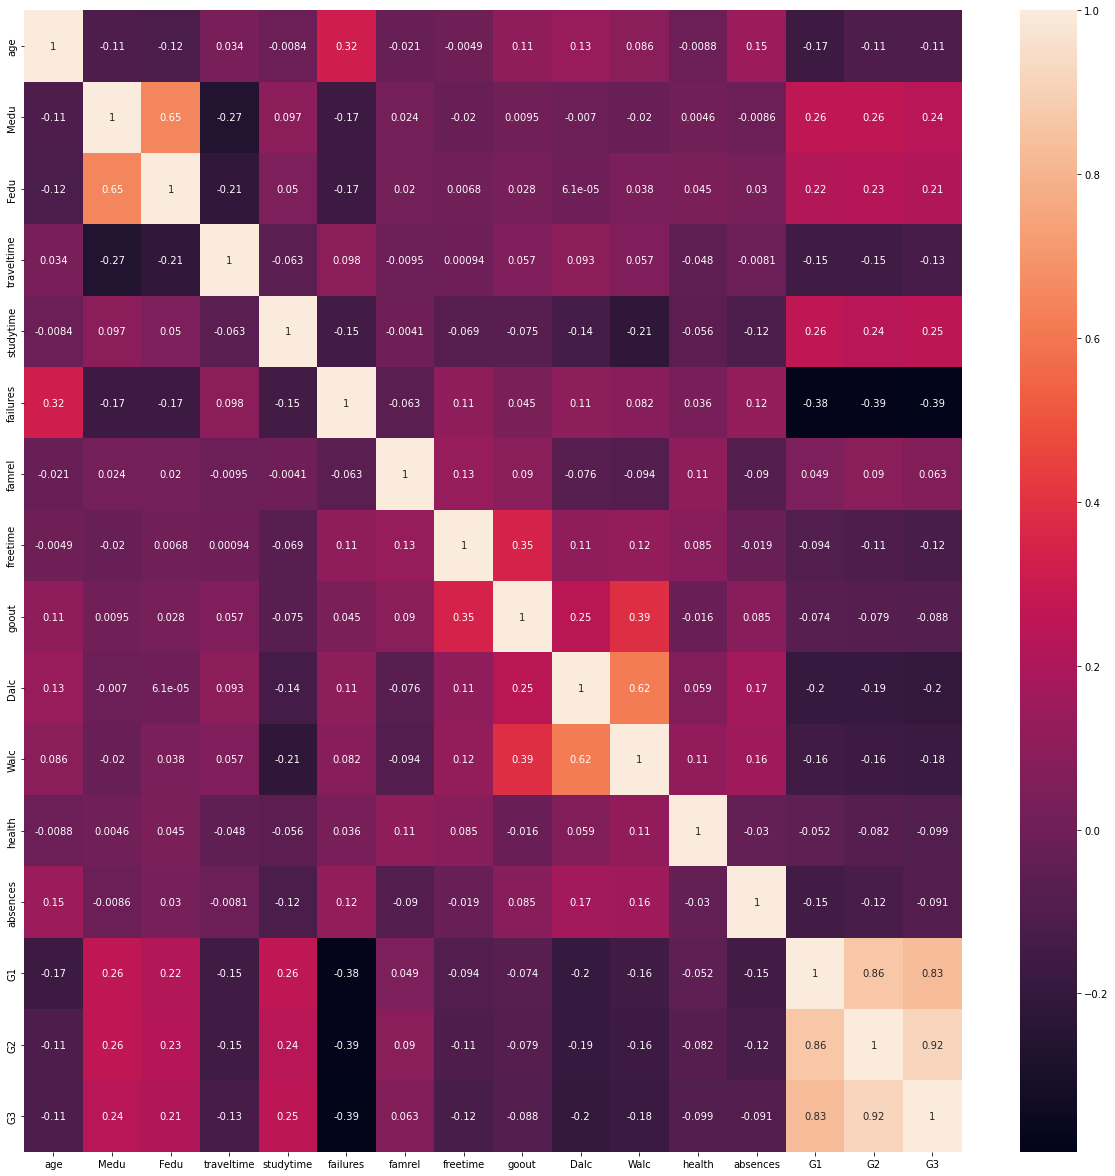

In [7]:
plt.figure(figsize=(21,21))
sns.heatmap(Dataset.corr(), annot =True )

In [65]:
Dataset.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')

<AxesSubplot:>

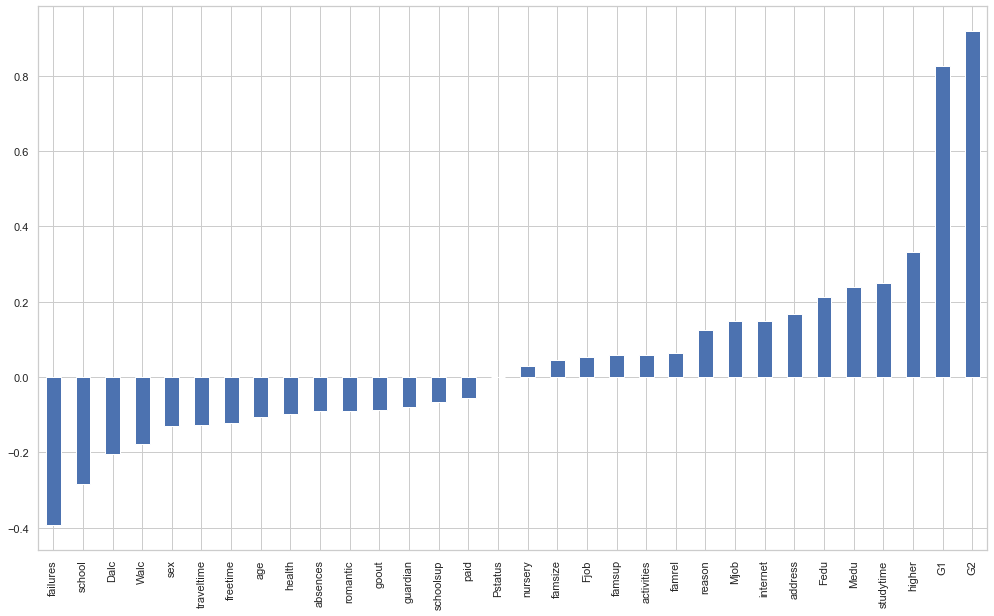

In [68]:
plt.figure(figsize=(17,10))
cor = Dataset.corr()['G3'][:-1].sort_values()
cor.plot(kind="bar")

11    104
10     97
13     82
12     72
14     63
15     49
16     36
9      35
8      35
17     29
18     15
0      15
7      10
6       3
19      2
1       1
5       1
Name: G3, dtype: int64
---------------------------


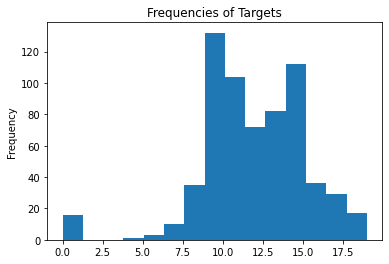

In [8]:
frequency = Dataset['G3'].value_counts()
print(frequency)
print("---------------------------")
plt.title('Frequencies of Targets')
Dataset['G3'].plot.hist(subplots=True, figsize=(20, 30), bins=15);

### Defining Dictionary Of Models

In [9]:
# MODELS = {'linear_r', 'svr', 'decision_tree_r', 'random_forest_r', 'knn_r', 'adaboost_r', 'gaussian_process_r', 'neural_network_r'}
MODELS = {'linear_r', 'svr', 'decision_tree_r', 'random_forest_r','knn_r', "adaboost", "GaussianProcessRegressor", "nn_r"}
student_performance_dict = {}  

## Train and Test set

In [10]:
Dataset.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [11]:
for column in Dataset:
    if type(Dataset[column][0]) == str:
        # if data in column is type string, we want to convert it to equivalent numerical labels
        label_encoder = LabelEncoder()
        integer_encoded = label_encoder.fit_transform(Dataset[column])
        Dataset[column] = integer_encoded

X = Dataset.iloc[:,:-1]
y = Dataset.iloc[:, -1:]
Dataset.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0,0,18,1,0,0,4,4,0,4,...,4,3,4,1,1,3,4,0,11,11
1,0,0,17,1,0,1,1,1,0,2,...,5,3,3,1,1,3,2,9,11,11
2,0,0,15,1,1,1,1,1,0,2,...,4,3,2,2,3,3,6,12,13,12
3,0,0,15,1,0,1,4,2,1,3,...,3,2,2,1,1,5,0,14,14,14
4,0,0,16,1,0,1,3,3,2,2,...,4,3,2,1,2,5,0,11,13,13


In [12]:
print(X[:0])

Empty DataFrame
Columns: [school, sex, age, address, famsize, Pstatus, Medu, Fedu, Mjob, Fjob, reason, guardian, traveltime, studytime, failures, schoolsup, famsup, paid, activities, nursery, higher, internet, romantic, famrel, freetime, goout, Dalc, Walc, health, absences, G1, G2]
Index: []

[0 rows x 32 columns]


In [13]:
X.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2
0,0,0,18,1,0,0,4,4,0,4,...,0,4,3,4,1,1,3,4,0,11
1,0,0,17,1,0,1,1,1,0,2,...,0,5,3,3,1,1,3,2,9,11
2,0,0,15,1,1,1,1,1,0,2,...,0,4,3,2,2,3,3,6,12,13
3,0,0,15,1,0,1,4,2,1,3,...,1,3,2,2,1,1,5,0,14,14
4,0,0,16,1,0,1,3,3,2,2,...,0,4,3,2,1,2,5,0,11,13


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, test_size=0.15, random_state=0)

y_train = y_train.to_numpy().reshape(-1)
y_test = y_test.to_numpy().reshape(-1)

In [15]:
StScale = StandardScaler()
StScale.fit(X_train)
X_train = StScale.transform(X_train)

X_test = StScale.transform(X_test)

In [16]:
StScale = StandardScaler()
X_train = StScale.fit_transform(X_train)
X_test = StScale.transform(X_test)

In [50]:
from tabulate import tabulate
def model_results(model):
    table = [["Parameters / Metrics", "Tuned"]]
    curr_model = model['model']
    
    if model['hyperparameters'] == 1:
        for param in curr_model.best_params_:
            table.append([param, curr_model.best_params_[param]])
    
    linear_r_predict = curr_model.predict(X_test)
    
    rmse = np.sqrt( mean_squared_error(y_test, linear_r_predict))
    model['rmse'] = rmse
    mse = mean_squared_error(y_test, linear_r_predict)
    model['mse'] = mse
    r2 = r2_score(y_test, linear_r_predict)
    model['r2'] = r2
    
    linear_r_predict_trn = curr_model.predict(X_train)
    mse_trn = mean_squared_error(y_train, linear_r_predict_trn)
    model['mse_trn'] = mse_trn
    r2_trn = r2_score(y_train, linear_r_predict_trn)
    model['r2_trn'] = r2_trn
    
    table.append(['Root Mean Squarred Error', rmse])
    table.append(['Mean Squarred Error', mse])
    table.append(['r2 Score ',r2])
    table.append(['Mean Squarred Error (train)', mse_trn])
    table.append(['r2 Score (train)',r2_trn])
    
    print(tabulate(table, headers='firstrow', tablefmt='grid'))

## Linear Regression

In [18]:
linear_r = LinearRegression()
linear_r.fit(X_train, y_train)

LinearRegression()

## Linear Regression Analysis

In [51]:
student_performance_dict['linear_r'] = {'model':linear_r, 'hyperparameters':0}
model_results(student_performance_dict['linear_r'])

+-----------------------------+----------+
| Parameters / Metrics        |    Tuned |
+=============================+==========+
| Root Mean Squarred Error    | 1.03275  |
+-----------------------------+----------+
| Mean Squarred Error         | 1.06657  |
+-----------------------------+----------+
| r2 Score                    | 0.861254 |
+-----------------------------+----------+
| Mean Squarred Error (train) | 1.56657  |
+-----------------------------+----------+
| r2 Score (train)            | 0.856289 |
+-----------------------------+----------+


## Support Vector Regression

In [20]:
svr = SVR(kernel='linear').fit(X_train,y_train)

In [21]:
parameters = {
    'C': scipy.stats.uniform(0.01, 1), 
    'gamma': scipy.stats.uniform(0.0001, 0.01)
}
svr_model = RandomizedSearchCV(svr, parameters, verbose=1, n_iter=5, random_state=0).fit(X_train, y_train)
svr_model.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


{'C': 0.6127633760716439, 'gamma': 0.005548831829968969}

In [22]:
svr_model.best_estimator_

SVR(C=0.6127633760716439, gamma=0.005548831829968969, kernel='linear')

## Support Vector Regression Analysis

In [52]:
student_performance_dict['svr'] = {'model':svr_model, 'hyperparameters':1}
model_results(student_performance_dict['svr'])

+-----------------------------+------------+
| Parameters / Metrics        |      Tuned |
+=============================+============+
| C                           | 0.612763   |
+-----------------------------+------------+
| gamma                       | 0.00554883 |
+-----------------------------+------------+
| Root Mean Squarred Error    | 0.944776   |
+-----------------------------+------------+
| Mean Squarred Error         | 0.892602   |
+-----------------------------+------------+
| r2 Score                    | 0.883885   |
+-----------------------------+------------+
| Mean Squarred Error (train) | 1.70198    |
+-----------------------------+------------+
| r2 Score (train)            | 0.843867   |
+-----------------------------+------------+


## Decision Tree Regression

In [24]:
tree = DecisionTreeRegressor().fit(X_train, y_train)

In [25]:
parameters = {
    'max_depth': scipy.stats.uniform(1, 10),
    'min_samples_split': scipy.stats.uniform(0, 0.01) 
}
tree_model = RandomizedSearchCV(tree, parameters, verbose=1, n_iter=20, random_state=0).fit(X_train, y_train)
tree_model.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


{'max_depth': 3.64555612104627, 'min_samples_split': 0.007742336894342167}

## Decision tree Analysis

In [53]:
student_performance_dict['decision_tree_r'] = {'model':tree_model, 'hyperparameters':1}
model_results(student_performance_dict['decision_tree_r'])

+-----------------------------+------------+
| Parameters / Metrics        |      Tuned |
+=============================+============+
| max_depth                   | 3.64556    |
+-----------------------------+------------+
| min_samples_split           | 0.00774234 |
+-----------------------------+------------+
| Root Mean Squarred Error    | 1.20453    |
+-----------------------------+------------+
| Mean Squarred Error         | 1.4509     |
+-----------------------------+------------+
| r2 Score                    | 0.811258   |
+-----------------------------+------------+
| Mean Squarred Error (train) | 1.74272    |
+-----------------------------+------------+
| r2 Score (train)            | 0.84013    |
+-----------------------------+------------+


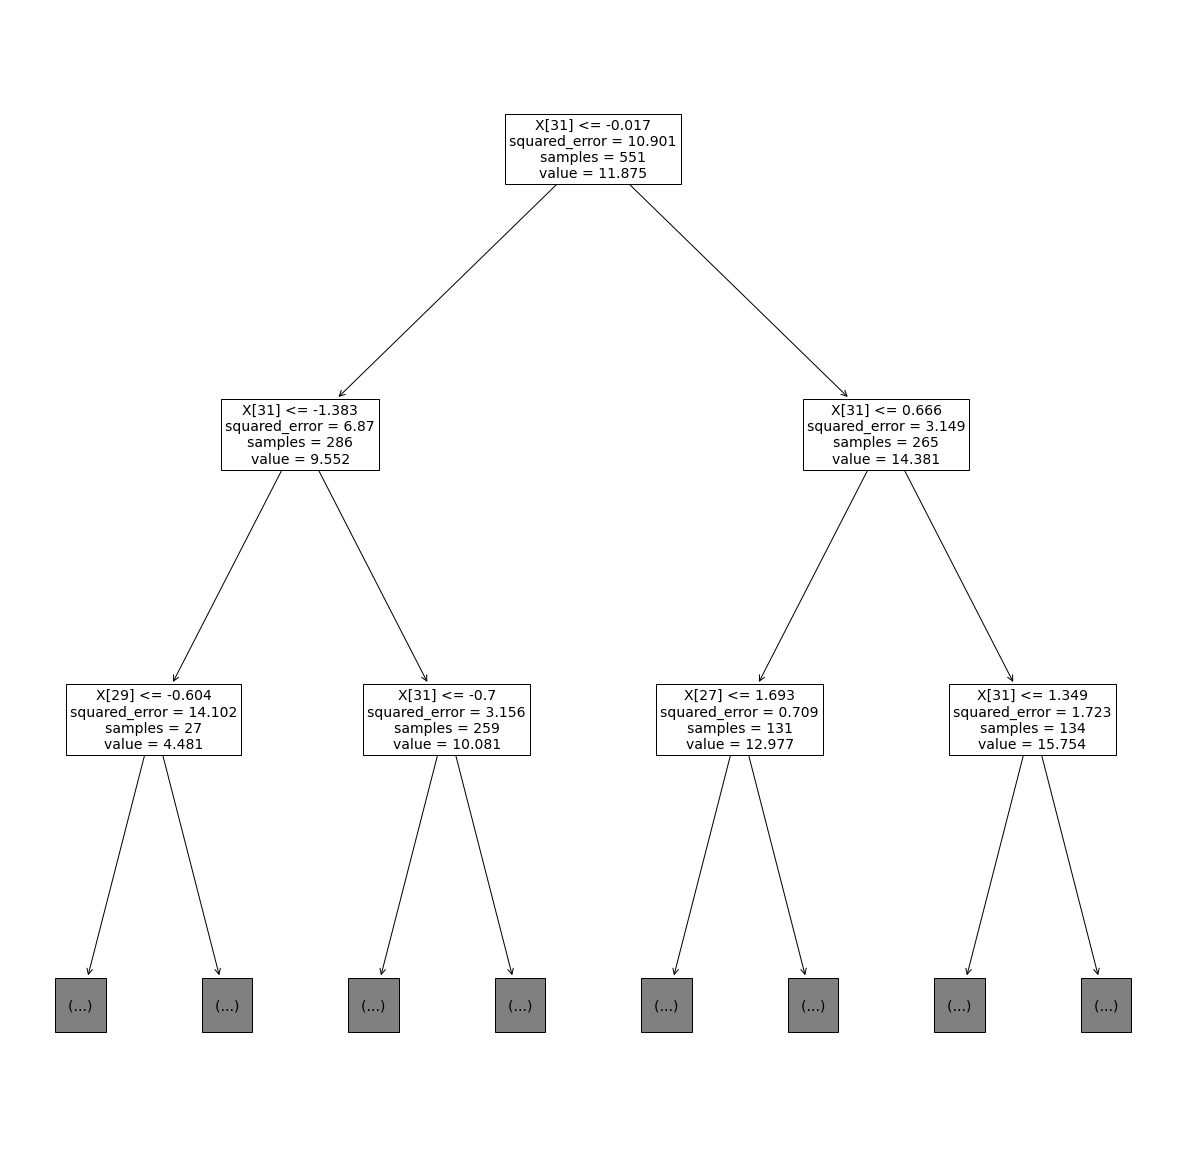

In [27]:
plt.figure(figsize=(21,21))
plot_tree(tree_model.best_estimator_, max_depth = 2, fontsize=14);

## Random Forest Regression

In [28]:
forest = RandomForestRegressor()
forest = forest.fit(X_train, y_train)

In [29]:
parameters = {
    'n_estimators': range(100,150),
    'max_depth': scipy.stats.uniform(1, 100),
}
forest_model = RandomizedSearchCV(forest, parameters, verbose=1, n_iter=20, random_state=0).fit(X_train, y_train)
forest_model.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


{'max_depth': 3.021839744032572, 'n_estimators': 105}

## Random Forest Analysis

In [54]:
student_performance_dict['random_forest_r'] = {'model':forest_model, 'hyperparameters':1}
model_results(student_performance_dict['random_forest_r'])

+-----------------------------+------------+
| Parameters / Metrics        |      Tuned |
+=============================+============+
| max_depth                   |   3.02184  |
+-----------------------------+------------+
| n_estimators                | 105        |
+-----------------------------+------------+
| Root Mean Squarred Error    |   1.0545   |
+-----------------------------+------------+
| Mean Squarred Error         |   1.11196  |
+-----------------------------+------------+
| r2 Score                    |   0.855349 |
+-----------------------------+------------+
| Mean Squarred Error (train) |   1.47377  |
+-----------------------------+------------+
| r2 Score (train)            |   0.864802 |
+-----------------------------+------------+


## K Nearest Neighbours Regression

In [31]:
knn =  KNeighborsRegressor()

In [32]:
parameters = {
    'n_neighbors': range(1, 100), 
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
    'weights': ['uniform', 'distance'], 
    'leaf_size': scipy.stats.uniform(1, 50)
}
knn_model = RandomizedSearchCV(knn, parameters,verbose=1,random_state=0,n_iter=100, cv =10).fit(X_train, y_train)
knn_model.best_params_

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


{'algorithm': 'auto',
 'leaf_size': 37.52210882833972,
 'n_neighbors': 6,
 'weights': 'uniform'}

### KNN Analysis

In [55]:
student_performance_dict['knn_r'] = {'model':knn_model, 'hyperparameters':1}
model_results(student_performance_dict['knn_r'])

+-----------------------------+--------------------+
| Parameters / Metrics        | Tuned              |
+=============================+====================+
| algorithm                   | auto               |
+-----------------------------+--------------------+
| leaf_size                   | 37.52210882833972  |
+-----------------------------+--------------------+
| n_neighbors                 | 6                  |
+-----------------------------+--------------------+
| weights                     | uniform            |
+-----------------------------+--------------------+
| Root Mean Squarred Error    | 1.7004234499962214 |
+-----------------------------+--------------------+
| Mean Squarred Error         | 2.8914399092970524 |
+-----------------------------+--------------------+
| r2 Score                    | 0.6238637252954313 |
+-----------------------------+--------------------+
| Mean Squarred Error (train) | 3.203569267997581  |
+-----------------------------+---------------

## Adaboost

In [34]:
AdaBoost = AdaBoostRegressor()
AdaBoost.fit(X_train,y_train)

AdaBoostRegressor()

In [35]:
param_distribution = {'learning_rate':scipy.stats.uniform(0.01,5),
                'n_estimators': range(1,250),
                'loss' : ['linear', 'square', 'exponential']}

In [36]:
adaBoost_model = RandomizedSearchCV(AdaBoost,
                                         param_distribution ,
                                         verbose=1, random_state=0,
                                         cv=5, n_iter=100).fit(X_train,y_train)


adaBoost_model.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'learning_rate': 0.05678352428266308,
 'loss': 'exponential',
 'n_estimators': 52}

### Adaboost Analysis

In [56]:
student_performance_dict['adaboost'] = {'model':adaBoost_model, 'hyperparameters':1}
model_results(student_performance_dict['adaboost'])

+-----------------------------+---------------------+
| Parameters / Metrics        | Tuned               |
+=============================+=====================+
| learning_rate               | 0.05678352428266308 |
+-----------------------------+---------------------+
| loss                        | exponential         |
+-----------------------------+---------------------+
| n_estimators                | 52                  |
+-----------------------------+---------------------+
| Root Mean Squarred Error    | 1.0951652417212943  |
+-----------------------------+---------------------+
| Mean Squarred Error         | 1.1993869066744607  |
+-----------------------------+---------------------+
| r2 Score                    | 0.8439763795348443  |
+-----------------------------+---------------------+
| Mean Squarred Error (train) | 1.4195334118465683  |
+-----------------------------+---------------------+
| r2 Score (train)            | 0.8697775366429441  |
+---------------------------

## GaussianProcessRegressor

In [38]:
GPR = GaussianProcessRegressor(kernel = 1.0 * RBF(1.0), normalize_y = False)

In [39]:
param_distribution = {"alpha":scipy.stats.reciprocal(1e-11, 1e-8),
                      'kernel':[Matern(i) for i in [0, 0.2, 0.5, 1,2,3,5]]  +
                      [RBF(i) for i in [0, 0.2, 0.5, 1,2,3,5]]+[DotProduct(i) for i in [0, 0.2, 0.5, 1,2,3,5]] +[WhiteKernel(i) for i in [0.2, 0.5, 1,2,3,5]] }


In [40]:
GPR_model = RandomizedSearchCV(GPR, param_distribution, cv=5, n_iter=20 ,random_state=0,verbose=1)
GPR_model.fit(X_train, y_train)
GPR_model.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\Asus\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:285: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:285: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))
C:\Users\Asus\a

{'alpha': 2.6352640400187257e-10, 'kernel': DotProduct(sigma_0=1)}

### GaussianProcessRegressor analysis

In [57]:
student_performance_dict['GaussianProcessRegressor'] = {'model':GPR_model, 'hyperparameters':1}
model_results(student_performance_dict['GaussianProcessRegressor'])

+-----------------------------+------------------------+
| Parameters / Metrics        | Tuned                  |
+=============================+========================+
| alpha                       | 2.6352640400187257e-10 |
+-----------------------------+------------------------+
| kernel                      | DotProduct(sigma_0=1)  |
+-----------------------------+------------------------+
| Root Mean Squarred Error    | 1.032780329071592      |
+-----------------------------+------------------------+
| Mean Squarred Error         | 1.0666352081172257     |
+-----------------------------+------------------------+
| r2 Score                    | 0.8612455363986857     |
+-----------------------------+------------------------+
| Mean Squarred Error (train) | 1.5665747260270924     |
+-----------------------------+------------------------+
| r2 Score (train)            | 0.8562885394921561     |
+-----------------------------+------------------------+


## neural_network_regression (MLPRegressor)

In [69]:
a = scipy.stats.uniform(2,3)
print(a)

In [42]:
nn_r = MLPRegressor()

In [71]:
param_distribution ={'max_iter': range(1000, 2000),
                     'hidden_layer_sizes': [(scipy.stats.randint(50,1000),scipy.stats.randint(50,1000),scipy.stats.randint(50,1000)), (50,50,50), (50,100,50), (100,)],
                     'learning_rate':['constant', 'invscaling', 'adaptive'],
                     'alpha': scipy.stats.reciprocal(0.00001, 0.1), 
                    'solver':["adam",'sgd','lbfgs'],
                    'activation':["identity",'tanh', "relu", "logistic"],
                    
}

In [72]:
nnr_model = RandomizedSearchCV(nn_r,
                                         param_distribution ,
                                         verbose=1, random_state=0,
                                         cv=5, n_iter=100).fit(X_train,y_train)


nnr_model.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1850) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1850) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1999) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1999) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multil

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1013) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1013) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1013) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1013) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Asus\anaconda3\lib\site-packages\sklearn\neural_network\_multil

{'activation': 'identity',
 'alpha': 0.052141652424472225,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'max_iter': 1011,
 'solver': 'lbfgs'}

### neural_network_regression analysis

In [75]:
student_performance_dict['nn_r'] = {'model':nnr_model, 'hyperparameters':1}
model_results(student_performance_dict['nn_r'])

+-----------------------------+----------------------+
| Parameters / Metrics        | Tuned                |
+=============================+======================+
| activation                  | identity             |
+-----------------------------+----------------------+
| alpha                       | 0.052141652424472225 |
+-----------------------------+----------------------+
| hidden_layer_sizes          | (100,)               |
+-----------------------------+----------------------+
| learning_rate               | constant             |
+-----------------------------+----------------------+
| max_iter                    | 1011                 |
+-----------------------------+----------------------+
| solver                      | lbfgs                |
+-----------------------------+----------------------+
| Root Mean Squarred Error    | 1.0327142639781892   |
+-----------------------------+----------------------+
| Mean Squarred Error         | 1.0664987510240131   |
+---------

------------

### Analyzing Models for Student Performance

+--------------------------+----------+------------+---------------+--------------------+----------+
| Model Name               |      MSE |   r2 Score |   MSE (train) |   r2 Score (train) |     RMSE |
+==========================+==========+============+===============+====================+==========+
| knn_r                    | 2.89144  |   0.623864 |       3.20357 |           0.706117 | 1.70042  |
+--------------------------+----------+------------+---------------+--------------------+----------+
| svr                      | 0.892602 |   0.883885 |       1.70198 |           0.843867 | 0.944776 |
+--------------------------+----------+------------+---------------+--------------------+----------+
| GaussianProcessRegressor | 1.06664  |   0.861246 |       1.56657 |           0.856289 | 1.03278  |
+--------------------------+----------+------------+---------------+--------------------+----------+
| random_forest_r          | 1.11196  |   0.855349 |       1.47377 |           0.864802 | 1

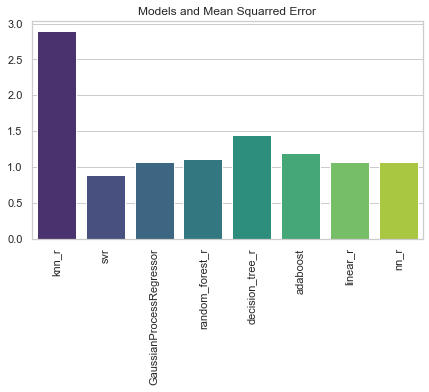

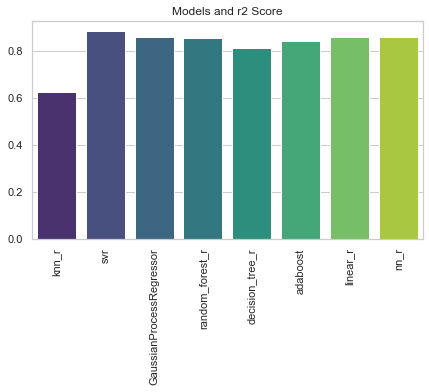

In [76]:
def cross_checking_model_results(dictionary):
    table = [["Model Name", "MSE", "r2 Score","MSE (train)", "r2 Score (train)" , "RMSE"]]
    x_models = []
    y_mse = []
    y_r2 = []
    y_mse_trn = []
    y_r2_trn = []
    y_rmse = []
    
    for model_key in MODELS:
        table.append([model_key, dictionary[model_key]['mse'], dictionary[model_key]['r2'],
                                 dictionary[model_key]['mse_trn'], dictionary[model_key]['r2_trn'],
                                                         dictionary[model_key]['rmse']            ])
        x_models.append(model_key)
        y_mse.append(dictionary[model_key]['mse'])
        y_r2.append(dictionary[model_key]['r2'])
        y_mse_trn.append(dictionary[model_key]['mse_trn'])
        y_r2_trn.append(dictionary[model_key]['r2_trn'])
        y_rmse.append(dictionary[model_key]['rmse'])
    print(tabulate(table, headers='firstrow', tablefmt='grid'))
    
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(7,4))
    ax1 = sns.barplot(x=x_models, y=y_mse, palette="viridis")
    ax1.set_title('Models and Mean Squarred Error')
    ax1.set_xticklabels(labels=x_models, rotation=90)
    plt.figure(figsize=(7,4))
    ax2 = sns.barplot(x=x_models, y=y_r2, palette="viridis")
    ax2.set_title('Models and r2 Score')
    ax2.set_xticklabels(labels=x_models, rotation=90)


cross_checking_model_results(student_performance_dict)

### Regression Dictionary
Exporting Model Data for Later Analysis and Comparison

In [64]:
with open('base_regression_dict.dictionary', 'rb') as config_dictionary_file:
    base_regression_dict = pickle.load(config_dictionary_file)

base_regression_dict['student_performance']= student_performance_dict

with open('base_regression_dict.dictionary', 'wb') as config_dictionary_file:
    pickle.dump(base_regression_dict, config_dictionary_file)